# SLM & IoT
By Marcelo Rovai @24Oct25

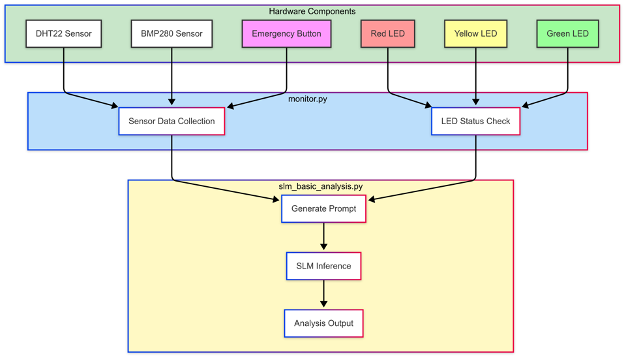

## Import Libraries

In [1]:
import time
import board
import adafruit_dht
import adafruit_bmp280
from gpiozero import LED, Button
import ollama

## Iniciate sensors and actuators

In [2]:
DHT22Sensor = adafruit_dht.DHT22(board.D16)
i2c = board.I2C()
bmp280Sensor = adafruit_bmp280.Adafruit_BMP280_I2C(i2c, address=0x76)
bmp280Sensor.sea_level_pressure = 1013.25

ledRed = LED(13)
ledYlw = LED(19)
ledGrn = LED(26)
button = Button(20)

## Create the Monitor Functions

In [3]:
def collect_data():
    try:
        temperature_dht = DHT22Sensor.temperature
        humidity = DHT22Sensor.humidity
        temperature_bmp = bmp280Sensor.temperature
        pressure = bmp280Sensor.pressure
        button_pressed = button.is_pressed
        return temperature_dht, humidity, temperature_bmp, pressure, button_pressed
    except RuntimeError:
        return None, None, None, None, None

def led_status():
    ledRedSts = ledRed.is_lit
    ledYlwSts = ledYlw.is_lit
    ledGrnSts = ledGrn.is_lit 
    return ledRedSts, ledYlwSts, ledGrnSts


def control_leds(red, yellow, green):
    ledRed.on() if red else ledRed.off()
    ledYlw.on() if yellow else ledYlw.off()
    ledGrn.on() if green else ledGrn.off()

## Calling the monitor functions to get all data

In [11]:
# control_leds(True, True, True)
control_leds(0, 0, 0)

In [12]:
ledRedSts, ledYlwSts, ledGrnSts  = led_status()
temp_dht, hum, temp_bmp, press, button_state  = collect_data()

In [13]:
if all(v is not None for v in [temp_dht, hum, temp_bmp, press]):
    print(f"DHT22 Temp: {temp_dht:.1f}°C, Humidity: {hum:.1f}%")
    print(f"BMP280 Temp: {temp_bmp:.1f}°C, Pressure: {press:.2f}hPa")
    print(f"Button {'pressed' if button_state else 'not pressed'}")
    print(f"Red LED {'is on' if ledRedSts else 'is off'}")
    print(f"Yellow LED {'is on' if ledYlwSts else 'is off'}")
    print(f"Green LED {'is on' if ledGrnSts else 'is off'}")

DHT22 Temp: 22.6°C, Humidity: 36.5%
BMP280 Temp: 23.2°C, Pressure: 908.85hPa
Button not pressed
Red LED is off
Yellow LED is off
Green LED is off


## Generating the Prompt

In [45]:
prompt = f"""
		You are an experienced environmental scientist. 
		Analyze the information received from an IoT system:

		DHT22 Temp: {temp_dht:.1f}°C and Humidity: {hum:.1f}%
		BMP280 Temp: {temp_bmp:.1f}°C and Pressure: {press:.2f}hPa
		Button {"pressed" if button_state else "not pressed"}
		Red LED {"is on" if ledRedSts else "is off"}
		Yellow LED {"is on" if ledYlwSts else "is off"}
		Green LED {"is on" if ledGrnSts else "is off"}

		Where,
		- The button, not pressed, shows a normal operation
		- The button, when pressed, shows an emergency
		- Red LED when is on, indicates a problem/emergency.
		- Yellow LED when is on indicates a warning situation.
		- Green LED when is on, indicates system is OK.

		If the temperature is over 20°C, mean a warning situation

		You should answer only with: "Activate Red LED" or 
		"Activate Yellow LED" or "Activate Green LED"

"""

## SLM Inference

In [48]:
MODEL = 'llama3.2:3b'
PROMPT = prompt
response = ollama.generate(
	model=MODEL, 
	prompt=PROMPT
	)

## Analisys Output

In [49]:
print(f"\nSmart IoT Analyser using {MODEL} model\n")

print(f"SYSTEM REAL DATA")
print(f" - DHT22 ==> Temp: {temp_dht:.1f}°C, Humidity: {hum:.1f}%")
print(f" - BMP280 => Temp: {temp_bmp:.1f}°C, Pressure: {press:.2f}hPa")
print(f" - Button {'pressed' if button_state else 'not pressed'}")
print(f" - Red LED {'is on' if ledRedSts else 'is off'}")
print(f" - Yellow LED {'is on' if ledYlwSts else 'is off'}")
print(f" - Green LED {'is on' if ledGrnSts else 'is off'}")

print(f"\n>> {MODEL} Response: {response['response']}")


Smart IoT Analyser using llama3.2:3b model

SYSTEM REAL DATA
 - DHT22 ==> Temp: 21.7°C, Humidity: 39.8%
 - BMP280 => Temp: 22.6°C, Pressure: 908.70hPa
 - Button pressed
 - Red LED is off
 - Yellow LED is off
 - Green LED is off

>> llama3.2:3b Response: Given the temperature of 22.6°C, which is above 20°C, I would recommend:

Activate Yellow LED


## Act on Output (Actuators)

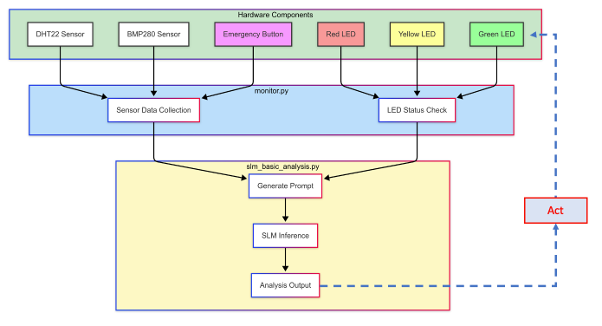

In [50]:
response_text = response['response']
response_text

'Given the temperature of 22.6°C, which is above 20°C, I would recommend:\n\nActivate Yellow LED'

In [51]:
def parse_llm_response(response_text):
    """Parse the LLM response to extract LED control instructions."""
    response_lower = response_text.lower()
    red_led = 'activate red led' in response_lower
    yellow_led = 'activate yellow led' in response_lower
    green_led = 'activate green led' in response_lower
    return (red_led, yellow_led, green_led)

In [52]:
red, yellow, green = parse_llm_response(response['response'])
red, yellow, green

(False, True, False)

In [53]:
control_leds(red, yellow, green)

In [21]:
led_status()

(False, True, False)

In [30]:
def output_actuator(response, MODEL):
    print(f"\nSmart IoT Actuator using {MODEL} model\n")
    
    print(f"SYSTEM REAL DATA")
    print(f" - DHT22 ==> Temp: {temp_dht:.1f}°C, Humidity: {hum:.1f}%")
    print(f" - BMP280 => Temp: {temp_bmp:.1f}°C, Pressure: {press:.2f}hPa")
    print(f" - Button {'pressed' if button_state else 'not pressed'}")
    
    print(f"\n>> {MODEL} Response: {response['response']}")
    
    # Control LEDs based on response
    red, yellow, green = parse_llm_response(response['response'])
    control_leds(red, yellow, green)
    
    print(f"\nSYSTEM ACTUATOR STATUS")
    ledRedSts, ledYlwSts, ledGrnSts  = led_status()
    print(f" - Red LED {'is on' if ledRedSts else 'is off'}")
    print(f" - Yellow LED {'is on' if ledYlwSts else 'is off'}")
    print(f" - Green LED {'is on' if ledGrnSts else 'is off'}")

In [27]:
output_actuator(response, MODEL)


Smart IoT Actuator using llama3.2:3b model

SYSTEM REAL DATA
 - DHT22 ==> Temp: 22.6°C, Humidity: 36.5%
 - BMP280 => Temp: 23.2°C, Pressure: 908.85hPa
 - Button not pressed

>> llama3.2:3b Response: Activate Yellow LED.

SYSTEM ACTUATOR STATUS
 - Red LED is off
 - Yellow LED is on
 - Green LED is off


In [28]:
def slm_inference(PROMPT, MODEL):
    response = ollama.generate(
    	model=MODEL, 
    	prompt=PROMPT
    	)
    return response

In [29]:
MODEL = 'llama3.2:3b'
PROMPT = prompt

In [57]:
response = slm_inference(PROMPT, MODEL)
output_actuator(response, MODEL)


Smart IoT Actuator using llama3.2:3b model

SYSTEM REAL DATA
 - DHT22 ==> Temp: 21.7°C, Humidity: 39.8%
 - BMP280 => Temp: 22.6°C, Pressure: 908.70hPa
 - Button pressed

>> llama3.2:3b Response: Based on the received data, since the temperature (21.7°C) is above 20°C and the humidity is below 40%, I would recommend:

Activate Yellow LED

SYSTEM ACTUATOR STATUS
 - Red LED is off
 - Yellow LED is on
 - Green LED is off


### Pressing the Button!

In [62]:
ledRedSts, ledYlwSts, ledGrnSts  = led_status()
temp_dht, hum, temp_bmp, press, button_state  = collect_data()
response = slm_inference(PROMPT, MODEL)
output_actuator(response, MODEL)


Smart IoT Actuator using llama3.2:3b model

SYSTEM REAL DATA
 - DHT22 ==> Temp: 20.6°C, Humidity: 31.3%
 - BMP280 => Temp: 21.5°C, Pressure: 911.71hPa
 - Button pressed

>> llama3.2:3b Response: Given the current temperature (21.7°C) which is below the threshold of 20°C and there are no other alarming values, I would not trigger any specific color change.

However, considering the high humidity level (39.8%), it might be a cause for concern if other parameters were also off the normal range.

Since there's only one parameter that's slightly above the warning zone and no other critical alarms, I will choose the green LED as an indicator of system status being OK.

SYSTEM ACTUATOR STATUS
 - Red LED is off
 - Yellow LED is off
 - Green LED is off


## Prompting Engineering

Looking at the answers, which are not always correct, we can see that the main issue is **Unreliable text parsing**. Using JSON to parse the answer should be much better!

#### Key Changes:

1. **Added JSON import**

2. **Fixed variable scope bug** - The previous code tried to use `temp_dht`, `hum`, etc. in the prompt *before* they were defined. The prompt is now created in a function after receiving sensor data.

3. **Changed to JSON format** - The prompt now asks for a structured JSON response:
   ```json
   {"red_led": true, "yellow_led": false, "green_led": false}
   ```

4. **Updated parser** - Now parses JSON instead of searching for text strings. Includes error handling and fallback to safe state (all LEDs off) if parsing fails.

#### Why JSON is Better:

- **More reliable**: No ambiguity about which LEDs to activate
- **Structured**: Clear true/false values instead of parsing text
- **Error-resistant**: The parser handles markdown code blocks (some models wrap JSON in ```) and provides safe fallback
- **Flexible**: Easy to add more fields later if needed

### New code

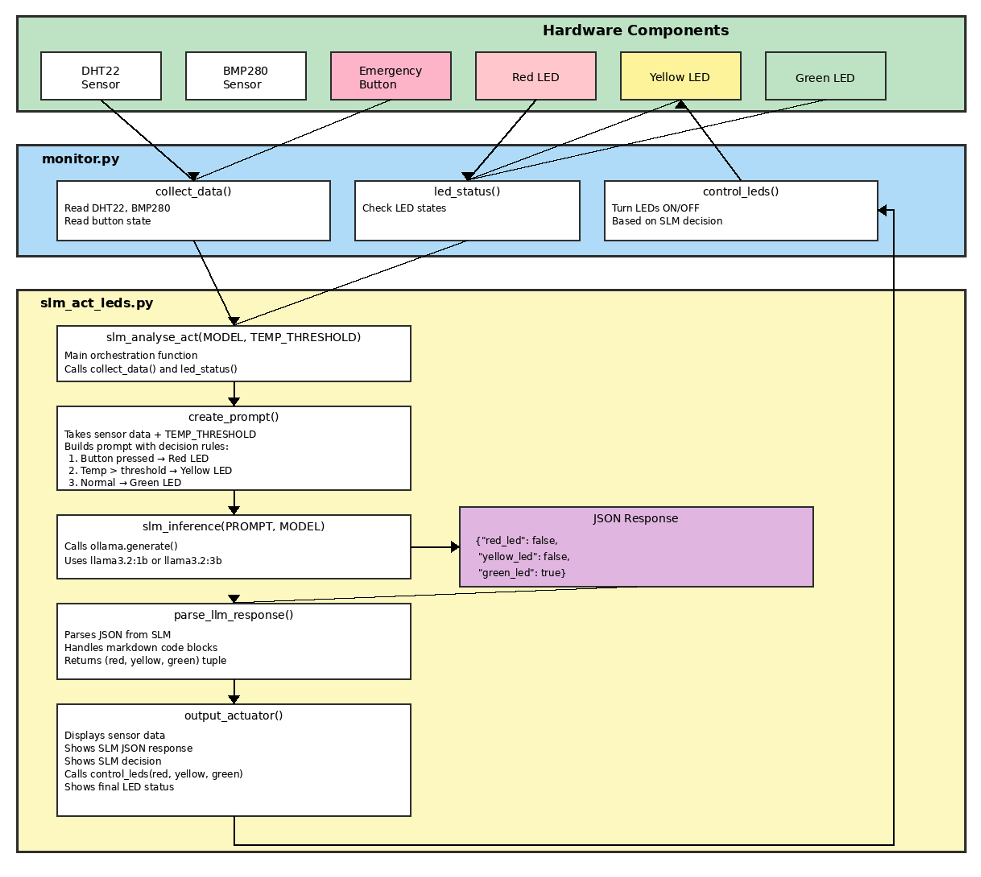

In [91]:
import json

In [145]:
def create_prompt(temp_dht, hum, temp_bmp, press, button_state, 
                  ledRedSts, ledYlwSts, ledGrnSts, TEMP_THRESHOLD):
	"""Create a prompt for the LLM with current sensor data."""
	return f"""
        You are controlling an IoT LED system. Analyze the sensor data and decide which ONE LED to activate.
        
        SENSOR DATA:
        - DHT22 Temperature: {temp_dht:.1f}°C
        - BMP280 Temperature: {temp_bmp:.1f}°C
        - Humidity: {hum:.1f}%
        - Pressure: {press:.2f}hPa
        - Button: {"PRESSED" if button_state else "NOT PRESSED"}
        
        TEMPERATURE THRESHOLD: {TEMP_THRESHOLD}°C
        
        DECISION RULES (apply in this priority order):
        1. IF button is PRESSED → Activate Red LED (EMERGENCY - highest priority)
        2. IF button is NOT PRESSED AND (DHT22 temp > {TEMP_THRESHOLD}°C OR BMP280 temp > {TEMP_THRESHOLD}°C) → Activate Yellow LED (WARNING)
        3. IF button is NOT PRESSED AND (DHT22 temp ≤ {TEMP_THRESHOLD}°C AND BMP280 temp ≤ {TEMP_THRESHOLD}°C) → Activate Green LED (NORMAL)
        
        CURRENT ANALYSIS:
        - Button status: {"PRESSED" if button_state else "NOT PRESSED"}
        - DHT22 temp ({temp_dht:.1f}°C) is {"OVER" if temp_dht > TEMP_THRESHOLD else "AT OR BELOW"} threshold ({TEMP_THRESHOLD}°C)
        - BMP280 temp ({temp_bmp:.1f}°C) is {"OVER" if temp_bmp > TEMP_THRESHOLD else "AT OR BELOW"} threshold ({TEMP_THRESHOLD}°C)
        
        Based on these rules, respond with ONLY a JSON object (no other text):
        {{"red_led": true, "yellow_led": false, "green_led": false}}
        
        Only ONE LED should be true, the other two must be false.
    """

In [144]:
def parse_llm_response(response_text):
    """Parse the LLM JSON response to extract LED control instructions."""
    try:
        # Clean the response - remove any markdown code blocks if present
        response_text = response_text.strip()
        if response_text.startswith('```'):
            # Extract JSON from markdown code block
            lines = response_text.split('\n')
            response_text = '\n'.join(lines[1:-1]) if len(lines) > 2 else response_text
        
        # Parse JSON
        data = json.loads(response_text)
        red_led = data.get('red_led', False)
        yellow_led = data.get('yellow_led', False)
        green_led = data.get('green_led', False)
        return (red_led, yellow_led, green_led)
    except (json.JSONDecodeError, KeyError) as e:
        print(f"Error parsing JSON response: {e}")
        print(f"Response was: {response_text}")
        # Fallback to safe state (all LEDs off)
        return (False, False, False)

In [132]:
def output_actuator(response, MODEL, temp_dht, hum, temp_bmp, press, button_state):
    print(f"\nSmart IoT Actuator using {MODEL} model\n")
    
    print(f"SYSTEM REAL DATA")
    print(f" - DHT22 ==> Temp: {temp_dht:.1f}°C, Humidity: {hum:.1f}%")
    print(f" - BMP280 => Temp: {temp_bmp:.1f}°C, Pressure: {press:.2f}hPa")
    print(f" - Button {'pressed' if button_state else 'not pressed'}")
    
    print(f"\n>> {MODEL} Response: {response['response']}")
    
    # Parse LLM response and use it directly (no validation)
    red, yellow, green = parse_llm_response(response['response'])
    print(f">> SLM decision: Red={red}, Yellow={yellow}, Green={green}")
    
    # Control LEDs based on SLM decision
    control_leds(red, yellow, green)
    
    print(f"\nSYSTEM ACTUATOR STATUS")
    ledRedSts, ledYlwSts, ledGrnSts  = led_status()
    print(f" - Red LED {'is on' if ledRedSts else 'is off'}")
    print(f" - Yellow LED {'is on' if ledYlwSts else 'is off'}")
    print(f" - Green LED {'is on' if ledGrnSts else 'is off'}")

In [133]:
def slm_analyse_act(MODEL, TEMP_THRESHOLD):
    """Main function to get sensor data, run SLM inference, and actuate LEDs."""
    # Get system info
    ledRedSts, ledYlwSts, ledGrnSts  = led_status()
    temp_dht, hum, temp_bmp, press, button_state  = collect_data()
    
    # Create prompt with current sensor data
    PROMPT = create_prompt(temp_dht, 
                           hum, 
                           temp_bmp, 
                           press, 
                           button_state, 
                           ledRedSts, 
                           ledYlwSts, 
                           ledGrnSts,
                           TEMP_THRESHOLD)
    
    # Analyse and actuate on LEDs
    response = slm_inference(PROMPT, MODEL)
    output_actuator(response, MODEL, temp_dht, hum, temp_bmp, press, button_state)

In [134]:
# Model to be used
MODEL = 'llama3.2:3b'

### Temp above the threshold

In [151]:
# Temperature threshold for warning
TEMP_THRESHOLD = 20.0

In [152]:
slm_analyse_act(MODEL, TEMP_THRESHOLD)


Smart IoT Actuator using llama3.2:3b model

SYSTEM REAL DATA
 - DHT22 ==> Temp: 21.5°C, Humidity: 28.8%
 - BMP280 => Temp: 22.4°C, Pressure: 910.04hPa
 - Button not pressed

>> llama3.2:3b Response: {"red_led": false, "yellow_led": true, "green_led": false}
>> SLM decision: Red=False, Yellow=True, Green=False

SYSTEM ACTUATOR STATUS
 - Red LED is off
 - Yellow LED is on
 - Green LED is off


### Temp below the threshold

In [154]:
# Temperature threshold for warning
TEMP_THRESHOLD = 25.0

In [155]:
slm_analyse_act(MODEL, TEMP_THRESHOLD)


Smart IoT Actuator using llama3.2:3b model

SYSTEM REAL DATA
 - DHT22 ==> Temp: 21.6°C, Humidity: 29.1%
 - BMP280 => Temp: 22.4°C, Pressure: 910.07hPa
 - Button not pressed

>> llama3.2:3b Response: {"red_led": false, "yellow_led": false, "green_led": true}
>> SLM decision: Red=False, Yellow=False, Green=True

SYSTEM ACTUATOR STATUS
 - Red LED is off
 - Yellow LED is off
 - Green LED is on


### Alarm Button pressed

In [156]:
slm_analyse_act(MODEL, TEMP_THRESHOLD)


Smart IoT Actuator using llama3.2:3b model

SYSTEM REAL DATA
 - DHT22 ==> Temp: 21.6°C, Humidity: 29.0%
 - BMP280 => Temp: 22.5°C, Pressure: 909.99hPa
 - Button pressed

>> llama3.2:3b Response: {"red_led": true, "yellow_led": false, "green_led": false}
>> SLM decision: Red=True, Yellow=False, Green=False

SYSTEM ACTUATOR STATUS
 - Red LED is on
 - Yellow LED is off
 - Green LED is off


In [157]:
control_leds(0,0,0)

##  Interacting with IoT Systems, using Natural Language Commands
- Adding User Question/Command

Let's create a new interactive prompt

In [175]:
def create_interactive_prompt(temp_dht, hum, temp_bmp, press, 
    button_state, ledRedSts, ledYlwSts, ledGrnSts, user_input):
	"""Create a prompt for interactive user commands and queries."""
	return f"""
You are an IoT system assistant controlling an environmental monitoring 
system with LED indicators.

CURRENT SYSTEM STATUS:
- DHT22: Temperature {temp_dht:.1f}°C, Humidity {hum:.1f}%
- BMP280: Temperature {temp_bmp:.1f}°C, Pressure {press:.2f}hPa
- Button: {"PRESSED" if button_state else "NOT PRESSED"}
- Red LED: {"ON" if ledRedSts else "OFF"}
- Yellow LED: {"ON" if ledYlwSts else "OFF"}
- Green LED: {"ON" if ledGrnSts else "OFF"}

USER REQUEST: "{user_input}"

INSTRUCTIONS:
You must analyze the user's request and respond with a JSON object 
containing two fields:

1. "message": A helpful text response to the user
2. "leds": LED control object with three boolean fields: 
"red_led", "yellow_led", "green_led"

EXAMPLES:

User: "what's the current temperature?"
Response: {{"message": "The current temperature is {temp_dht:.1f}°C from DHT22 and {temp_bmp:.1f}°C from BMP280.", "leds": {{"red_led": {str(ledRedSts).lower()}, "yellow_led": {str(ledYlwSts).lower()}, "green_led": {str(ledGrnSts).lower()}}}}}

User: "turn on the yellow led"
Response: {{"message": "Yellow LED turned on.", "leds": {{"red_led": false, "yellow_led": true, "green_led": false}}}}

User: "if temperature is above 20°C, turn on yellow led"
Response: {{"message": "Temperature is {temp_dht:.1f}°C, which is {'above' if temp_dht > 20 else 'below or equal to'} 20°C. {'Yellow LED turned on.' if temp_dht > 20 else 'No action taken.'}", "leds": {{"red_led": false, "yellow_led": {str(temp_dht > 20).lower()}, "green_led": {str(temp_dht <= 20).lower()}}}}}

User: "if button is pressed, turn on red led"
Response: {{"message": "Button is {'pressed' if button_state else 'not pressed'}. {'Red LED turned on.' if button_state else 'No action taken.'}", "leds": {{"red_led": {str(button_state).lower()}, "yellow_led": false, "green_led": {str(not button_state).lower()}}}}}

User: "turn on all leds"
Response: {{"message": "All LEDs turned on.", "leds": {{"red_led": true, "yellow_led": true, "green_led": true}}}}

User: "turn off all leds"
Response: {{"message": "All LEDs turned off.", "leds": {{"red_led": false, "yellow_led": false, "green_led": false}}}}

User: "will it rain?"
Response: {{"message": "Based on pressure of {press:.2f}hPa and humidity of {hum:.1f}%, [your analysis here]. LEDs unchanged.", "leds": {{"red_led": {str(ledRedSts).lower()}, "yellow_led": {str(ledYlwSts).lower()}, "green_led": {str(ledGrnSts).lower()}}}}}

User: "if button is pressed, switch (change, reverse)the led states"
Response: {{"message": "Button is {'pressed' if button_state else 'not pressed'}. {'LED states switched.' if button_state else 'No action taken.'}", "leds": {{"red_led": {str(not ledRedSts and button_state).lower()}, "yellow_led": {str(not ledYlwSts and button_state).lower()}, "green_led": {str(not ledGrnSts and button_state).lower()}}}}}

RULES:
- Always respond with valid JSON containing both "message" and "leds" fields
- If the user is just asking for information, keep the current LED states
- If the user gives a command, update the LED states accordingly
- If the command has a condition (if/when), evaluate it based on current sensor data
- Be conversational and helpful in your message
- Only ONE LED should be on at a time UNLESS the user explicitly asks for multiple LEDs

Respond with ONLY the JSON, no other text.
"""


In [159]:
def parse_interactive_response(response_text):
    """Parse the interactive SLM JSON response."""
    try:
        # Clean the response
        response_text = response_text.strip()
        if response_text.startswith('```'):
            lines = response_text.split('\n')
            response_text = '\n'.join(lines[1:-1]) if len(lines) > 2 else response_text
            response_text = response_text.replace('```json', '').replace('```', '').strip()
        
        # Parse JSON
        data = json.loads(response_text)
        
        # Extract message
        message = data.get('message', 'No response provided.')
        
        # Extract LED states
        leds = data.get('leds', {})
        red_led = leds.get('red_led', False)
        yellow_led = leds.get('yellow_led', False)
        green_led = leds.get('green_led', False)
        
        return message, (red_led, yellow_led, green_led)
    
    except (json.JSONDecodeError, KeyError) as e:
        print(f"Error parsing JSON response: {e}")
        print(f"Response was: {response_text}")
        return "Error: Could not parse SLM response.", (False, False, False)

In [160]:
def display_system_status(temp_dht, hum, temp_bmp, press, button_state, ledRedSts, ledYlwSts, ledGrnSts):
    """Display comprehensive system status."""
    print("\n" + "="*60)
    print("SYSTEM STATUS")
    print("="*60)
    print(f"DHT22 Sensor:  Temp = {temp_dht:.1f}°C, Humidity = {hum:.1f}%")
    print(f"BMP280 Sensor: Temp = {temp_bmp:.1f}°C, Pressure = {press:.2f}hPa")
    print(f"Button:        {'PRESSED' if button_state else 'NOT PRESSED'}")
    print(f"\nLED Status:")
    print(f"  Red LED:    {'●' if ledRedSts else '○'} {'ON' if ledRedSts else 'OFF'}")
    print(f"  Yellow LED: {'●' if ledYlwSts else '○'} {'ON' if ledYlwSts else 'OFF'}")
    print(f"  Green LED:  {'●' if ledGrnSts else '○'} {'ON' if ledGrnSts else 'OFF'}")
    print("="*60)

In [165]:
def interactive_mode(MODEL, USER_INPUT):
    user_input = USER_INPUT.strip()
    
    # if user_input.lower() in ['exit', 'quit', 'q']:
    #     print("\nExiting interactive mode. Goodbye!")
    #     break
    
    # Get current system status
    ledRedSts, ledYlwSts, ledGrnSts = led_status()
    temp_dht, hum, temp_bmp, press, button_state = collect_data()
    
    # Handle status command
    if user_input.lower() == 'status':
        display_system_status(temp_dht, hum, temp_bmp, press, button_state, 
                            ledRedSts, ledYlwSts, ledGrnSts)
    
    # Check if sensor data is valid
    if any(v is None for v in [temp_dht, hum, temp_bmp, press]):
        print("Assistant: Error - Unable to read sensor data. Please try again.")
    
    # Create prompt with user input
    PROMPT = create_interactive_prompt(temp_dht, hum, temp_bmp, press, button_state,
                                      ledRedSts, ledYlwSts, ledGrnSts, user_input)
    
    # Get SLM response
    print("Assistant: [Thinking...]")
    response = slm_inference(PROMPT, MODEL)
    
    # Parse response
    message, (red, yellow, green) = parse_interactive_response(response['response'])
    
    # Display assistant's message
    print(f"Assistant: {message}")
    
    # Control LEDs based on response
    control_leds(red, yellow, green)
    
    # Display updated system status
    ledRedSts, ledYlwSts, ledGrnSts = led_status()
    print(f"\nLED Update: Red={'ON' if ledRedSts else 'OFF'}, "
          f"Yellow={'ON' if ledYlwSts else 'OFF'}, "
          f"Green={'ON' if ledGrnSts else 'OFF'}\n")

In [166]:
MODEL = 'llama3.2:3b'

In [168]:
USER_INPUT = "What's the current temperature?"
interactive_mode(MODEL, USER_INPUT)

Assistant: [Thinking...]
Assistant: The current temperature is 21.7°C from DHT22 and 24.3°C from BMP280.

LED Update: Red=OFF, Yellow=OFF, Green=OFF



In [169]:
USER_INPUT = "What are the actual conditions??"
interactive_mode(MODEL, USER_INPUT)

Assistant: [Thinking...]
Assistant: The actual conditions are: Temperature 23.6°C from DHT22 and 24.3°C from BMP280.

LED Update: Red=OFF, Yellow=OFF, Green=OFF



In [170]:
USER_INPUT = "Give me the actual data from all sensors"
interactive_mode(MODEL, USER_INPUT)

Assistant: [Thinking...]
Assistant: Actual data from all sensors:
DHT22: Temperature 23.5°C, Humidity 20.9%
BMP280: Temperature 24.3°C, Pressure 906.52hPa
Button: NOT PRESSED

LED Update: Red=OFF, Yellow=OFF, Green=OFF



In [171]:
USER_INPUT = "How about rain today?"
interactive_mode(MODEL, USER_INPUT)

Assistant: [Thinking...]
Assistant: Based on pressure of 906.54hPa and humidity of 20.1%, it appears that there is no significant weather pattern at this moment. The barometric pressure suggests a stable atmosphere, while the relatively low humidity indicates dry conditions. LEDs unchanged.

LED Update: Red=OFF, Yellow=OFF, Green=OFF



In [177]:
USER_INPUT = "If the button is pressed, change the LED states"
interactive_mode(MODEL, USER_INPUT)

Assistant: [Thinking...]
Assistant: Button is pressed. Red LED turned on.

LED Update: Red=ON, Yellow=OFF, Green=OFF



In [172]:
USER_INPUT = "Turn on all LEDs"
interactive_mode(MODEL, USER_INPUT)

Assistant: [Thinking...]
Assistant: All LEDs turned on.

LED Update: Red=ON, Yellow=ON, Green=ON



In [178]:
USER_INPUT = "Turn OFF all LEDs"
interactive_mode(MODEL, USER_INPUT)

Assistant: [Thinking...]
Assistant: All LEDs turned off.

LED Update: Red=OFF, Yellow=OFF, Green=OFF



In [179]:
USER_INPUT = "Display system status"
interactive_mode(MODEL, USER_INPUT)

Assistant: [Thinking...]
Assistant: Display system status

LED Update: Red=OFF, Yellow=OFF, Green=OFF



In [180]:
USER_INPUT = "status"
interactive_mode(MODEL, USER_INPUT)


SYSTEM STATUS
DHT22 Sensor:  Temp = 23.6°C, Humidity = 21.5%
BMP280 Sensor: Temp = 24.4°C, Pressure = 906.41hPa
Button:        NOT PRESSED

LED Status:
  Red LED:    ○ OFF
  Yellow LED: ○ OFF
  Green LED:  ○ OFF
Assistant: [Thinking...]
Assistant: Current system status: Temperature 23.6°C from DHT22 and 24.4°C from BMP280.

LED Update: Red=OFF, Yellow=OFF, Green=OFF



In [181]:
USER_INPUT = "If temperature is above 20°C, turn on yellow LED"
interactive_mode(MODEL, USER_INPUT)

Assistant: [Thinking...]
Assistant: Temperature is above 20°C. Yellow LED turned on.

LED Update: Red=OFF, Yellow=ON, Green=OFF



In [185]:
USER_INPUT = "Ligar todos os LEDs"
interactive_mode(MODEL, USER_INPUT)

Assistant: [Thinking...]
Assistant: All LEDs turned on.

LED Update: Red=ON, Yellow=ON, Green=ON



In [184]:
USER_INPUT = "Apagar todos os LEDs"
interactive_mode(MODEL, USER_INPUT)

Assistant: [Thinking...]
Assistant: Apagar todos os LEDs

LED Update: Red=OFF, Yellow=OFF, Green=OFF



## Latency Analysis

In [186]:
def interactive_mode(MODEL, USER_INPUT):
    user_input = USER_INPUT.strip()
    
    # if user_input.lower() in ['exit', 'quit', 'q']:
    #     print("\nExiting interactive mode. Goodbye!")
    #     break
    
    # Get current system status
    ledRedSts, ledYlwSts, ledGrnSts = led_status()
    temp_dht, hum, temp_bmp, press, button_state = collect_data()
    
    # Handle status command
    if user_input.lower() == 'status':
        display_system_status(temp_dht, hum, temp_bmp, press, button_state, 
                            ledRedSts, ledYlwSts, ledGrnSts)
    
    # Check if sensor data is valid
    if any(v is None for v in [temp_dht, hum, temp_bmp, press]):
        print("Assistant: Error - Unable to read sensor data. Please try again.")
    
    # Create prompt with user input
    PROMPT = create_interactive_prompt(temp_dht, hum, temp_bmp, press, button_state,
                                      ledRedSts, ledYlwSts, ledGrnSts, user_input)
    
    # Get SLM response
    print("Assistant: [Thinking...]")
    response = slm_inference(PROMPT, MODEL)
    
    # Parse response
    message, (red, yellow, green) = parse_interactive_response(response['response'])
    
    # Display assistant's message
    print(f"Assistant: {message}")
    
    # Control LEDs based on response
    control_leds(red, yellow, green)
    
    # Display updated system status
    ledRedSts, ledYlwSts, ledGrnSts = led_status()
    print(f"\nLED Update: Red={'ON' if ledRedSts else 'OFF'}, "
          f"Yellow={'ON' if ledYlwSts else 'OFF'}, "
          f"Green={'ON' if ledGrnSts else 'OFF'}\n")

    # Display Latency
    print(f"\nTotal Duration: {(response['total_duration']/1e9):.2f} seconds")
    print(f"prompt_eval_duration: {(response['prompt_eval_duration']/1e9):.2f} s")
    print(f"load_duration: {(response['load_duration']/1e9):.2f} s")
    print(f"eval_count: {response['eval_count']}")
    print(f"eval_duration: {(response['eval_duration']/1e9):.2f} s")
    print(f"eval_rate: {response['eval_count']/(response['eval_duration']/1e9):.2f} tokens/s")

In [188]:
USER_INPUT = "turn off all LEDs"
interactive_mode(MODEL, USER_INPUT)

Assistant: [Thinking...]
Assistant: All LEDs turned off.

LED Update: Red=OFF, Yellow=OFF, Green=OFF


Total Duration: 88.81 seconds
prompt_eval_duration: 80.41 s
load_duration: 1.98 s
eval_count: 32
eval_duration: 6.41 s
eval_rate: 4.99 tokens/s


`The prompt evaluation is our botleneck`

### Testing with another model

In [190]:
MODEL = 'gemma3n:e2b'
USER_INPUT = "turn off all LEDs"
interactive_mode(MODEL, USER_INPUT)

Assistant: [Thinking...]
Assistant: All LEDs turned off.

LED Update: Red=OFF, Yellow=OFF, Green=OFF


Total Duration: 85.76 seconds
prompt_eval_duration: 75.31 s
load_duration: 0.38 s
eval_count: 56
eval_duration: 10.07 s
eval_rate: 5.56 tokens/s


`This model decrease a litle the response time, but not enought`

### Testing with Pydantic

In [191]:
from pydantic import BaseModel, Field

# --- Pydantic Models for Structured Output ---

class LEDControl(BaseModel):
    """The required state for the three LEDs."""
    red_led: bool = Field(description="Turn the red LED on (true) or off (false).")
    yellow_led: bool = Field(description="Turn the yellow LED on (true) or off (false).")
    green_led: bool = Field(description="Turn the green LED on (true) or off (false).")

class SLMResponse(BaseModel):
    """The complete response object from the SLM."""
    message: str = Field(description="A helpful text response to the user.")
    leds: LEDControl

# Generate the JSON schema once
RESPONSE_SCHEMA_JSON = json.dumps(SLMResponse.model_json_schema(), indent=2)

#### New Optimized Prompt

In [192]:
def create_interactive_prompt(temp_dht, hum, temp_bmp, press, 
    button_state, ledRedSts, ledYlwSts, ledGrnSts, user_input):
	"""Create a concise and structured prompt for the SLM."""
    
	# 1. Concise System Status (Optimized for Prompt Evaluation Speed)
	status_str = (
        f"STATUS: "
        f"DHT_T={temp_dht:.1f}C, DHT_H={hum:.1f}%, "
        f"BMP_T={temp_bmp:.1f}C, BMP_P={press:.2f}hPa, "
        f"BTN={'1' if button_state else '0'}, "
        f"LED_R={'1' if ledRedSts else '0'}, "
        f"LED_Y={'1' if ledYlwSts else '0'}, "
        f"LED_G={'1' if ledGrnSts else '0'}"
    )

	return f"""
You are an IoT assistant.
{status_str}

USER REQUEST: "{user_input}"

INSTRUCTIONS:
Analyze the request and respond with a JSON object that strictly follows the provided JSON Schema.
- If the user asks for info, keep the current LED states (R={ledRedSts}, Y={ledYlwSts}, G={ledGrnSts}).
- Evaluate conditional commands (e.g., 'if temp > 20C') using the STATUS data.
- Only ONE LED should be on UNLESS the user explicitly asks for multiple.

REQUIRED JSON SCHEMA:
---
{RESPONSE_SCHEMA_JSON}
---

Respond with ONLY the JSON, no other text.
"""

#### New parse_interactive_response

In [195]:
def parse_interactive_response(response_text):
    """Parse the interactive SLM JSON response using Pydantic for validation."""
    try:
        # --- Robust JSON Extraction ---
        # 1. Strip whitespace and non-essential text markers
        cleaned_text = response_text.strip()
        cleaned_text = cleaned_text.replace('```json', '').replace('```', '').strip()
        
        # 2. Find the start of the JSON object (first '{')
        start_index = cleaned_text.find('{')
        if start_index == -1:
            raise ValueError("No starting JSON object brace '{' found.")

        # 3. Find the end of the JSON object (last '}')
        # This handles cases where the model might stop mid-generation or add text after the JSON.
        end_index = cleaned_text.rfind('}')
        if end_index == -1 or end_index < start_index:
            raise ValueError("No ending JSON object brace '}' found.")
        
        # 4. Slice the clean JSON string
        json_str = cleaned_text[start_index : end_index + 1]

        # --- Pydantic Validation ---
        
        # Use Pydantic to parse and validate the JSON
        # This is fast and enforces the strict schema.
        response_data = SLMResponse.model_validate_json(json_str)
        
        # Extract data from the validated Pydantic object
        message = response_data.message
        red_led = response_data.leds.red_led
        yellow_led = response_data.leds.yellow_led
        green_led = response_data.leds.green_led
        
        return message, (red_led, yellow_led, green_led)
    
    except Exception as e:
        # Catch all errors (Pydantic, ValueErrors, etc.) and report
        print(f"Error parsing/validating SLM response: {type(e).__name__}: {e}")
        print(f"Response was (Raw): {response_text}")
        try:
             # Try to print the extracted string for debugging
             print(f"Response was (Extracted): {json_str}")
        except:
             pass
        return "Error: Could not parse or validate SLM response format.", (False, False, False)

In [197]:
MODEL = 'gemma3n:e2b'
USER_INPUT = "turn on Yellow LED"
interactive_mode(MODEL, USER_INPUT)

Assistant: [Thinking...]
Assistant: Turning on the yellow LED.

LED Update: Red=OFF, Yellow=ON, Green=OFF


Total Duration: 65.68 seconds
prompt_eval_duration: 55.49 s
load_duration: 0.33 s
eval_count: 57
eval_duration: 9.85 s
eval_rate: 5.79 tokens/s


In [199]:
MODEL = 'llama3.2:3b'
USER_INPUT = "turn off Yellow LED"
interactive_mode(MODEL, USER_INPUT)

Assistant: [Thinking...]
Assistant: Yellow LED turned off.

LED Update: Red=OFF, Yellow=OFF, Green=OFF


Total Duration: 60.27 seconds
prompt_eval_duration: 51.54 s
load_duration: 0.16 s
eval_count: 42
eval_duration: 8.57 s
eval_rate: 4.90 tokens/s


## Extras

In [182]:
control_leds(0,0,0)